In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import norm
import requests
from io import StringIO
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [48]:
import lseg.data as ld
ld.open_session()


<lseg.data.session.Definition object at 0x177e06c90 {name='workspace'}>

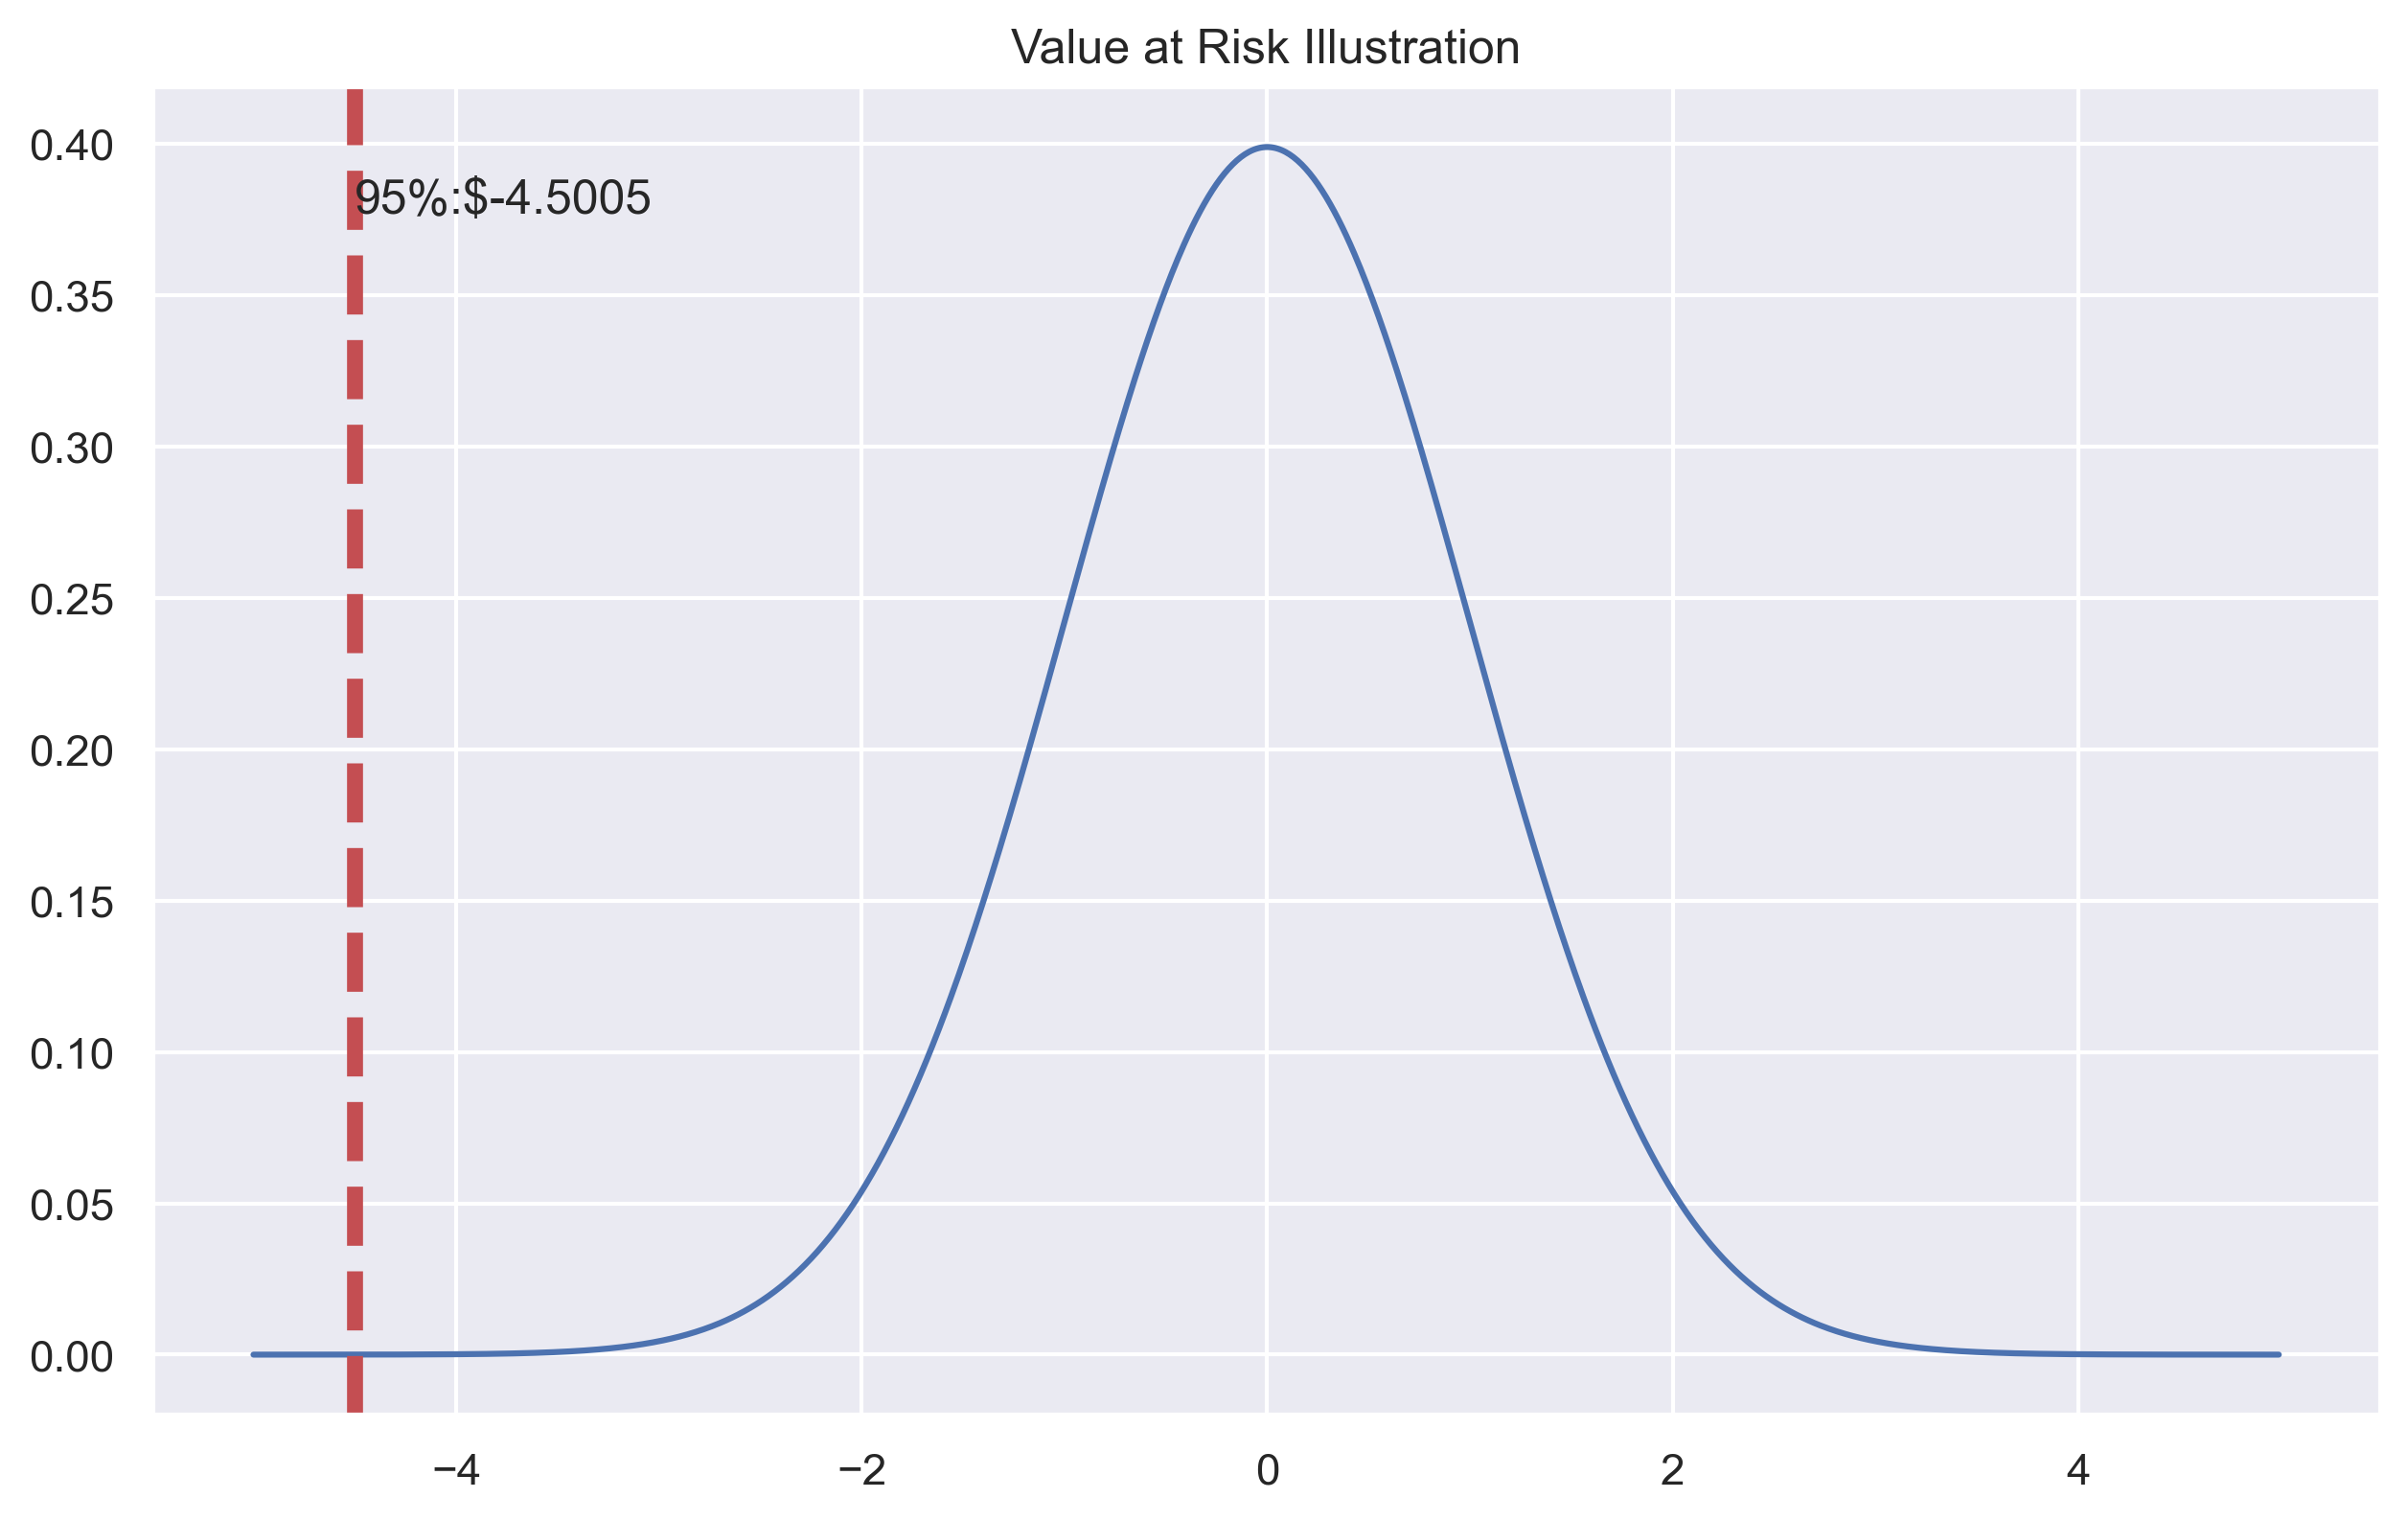

In [49]:
mean = 0
std_dev = 1
x = np.arange(-5, 5, 0.01)
y = norm.pdf(x, mean, std_dev)
pdf = plt.plot(x, y)
min_ylim, max_ylim = plt.ylim()
plt.text(np.percentile(x, 5), max_ylim * 0.9, '95%:${:.4f}'
         .format(np.percentile(x, 5)))
plt.axvline(np.percentile(x, 5), color='r', linestyle='dashed',
            linewidth=4)
plt.title('Value at Risk Illustration')
plt.show()

In [50]:
RICS = ["TSLA.N", "MSFT.O", "NVDA.O"]
ts = ld.get_data(RICS,
                   [
                    'TR.PriceClose(SDate=2021-01-02,EDate=2025-10-01,Frq=D).date',
                    'TR.PriceClose(SDate=2021-01-02,EDate=2025-10-01,Frq=D)'
                   ])
ts2 = ts.drop_duplicates()
ts2

,Instrument,Date,Price Close
0,TSLA.N,2021-01-04,243.29309
1,TSLA.N,2021-01-05,245.036422
2,TSLA.N,2021-01-06,252.063081
3,TSLA.N,2021-01-07,272.039728
4,TSLA.N,2021-01-08,293.379707
...,...,...,...
3570,NVDA.O,2025-09-24,176.97
3571,NVDA.O,2025-09-25,177.69
3572,NVDA.O,2025-09-26,178.19
3573,NVDA.O,2025-09-29,181.85


In [51]:
stocks = ts2.pivot(index="Date", columns="Instrument", values="Price Close")
stocks

Instrument,MSFT.O,NVDA.O,TSLA.N
Date,,,
2021-01-04,217.69,13.1135,243.29309
2021-01-05,217.9,13.40475,245.036422
2021-01-06,212.25,12.6145,252.063081
2021-01-07,218.29,13.344,272.039728
2021-01-08,219.62,13.27675,293.379707
...,...,...,...
2025-09-25,507.03,177.69,423.37
2025-09-26,511.46,178.19,440.295
2025-09-29,514.6,181.85,443.385


In [52]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()
stocks_returns

Instrument,MSFT.O,NVDA.O,TSLA.N
Date,,,
2021-01-05,0.000964,0.021967,0.00714
2021-01-06,-0.026271,-0.060762,0.028273
2021-01-07,0.02806,0.05622,0.076269
2021-01-08,0.006074,-0.005052,0.07552
2021-01-11,-0.009746,0.025635,-0.082121
...,...,...,...
2025-09-24,0.001805,-0.008216,0.039368
2025-09-25,-0.006135,0.00406,-0.044668
2025-09-26,0.008699,0.00281,0.039198


In [53]:
stocks_returns_mean = stocks_returns.mean()
weights  = np.random.random(len(stocks_returns.columns))
weights /= np.sum(weights)
#weights =  np.array([.333, .333, .333], dtype='float')
cov_var = stocks_returns.cov()
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [54]:
weights

array([0.71409977, 0.19052977, 0.09537045])

In [55]:
stocks_returns_mean

Instrument
MSFT.O    0.000728
NVDA.O    0.002231
TSLA.N    0.000507
dtype: Float64

In [56]:
print(stocks_returns_mean)
print(weights)
print(cov_var)
print(port_std) 

Instrument
MSFT.O    0.000728
NVDA.O    0.002231
TSLA.N    0.000507
dtype: Float64
[0.71409977 0.19052977 0.09537045]
Instrument    MSFT.O    NVDA.O    TSLA.N
Instrument                              
MSFT.O      0.000268  0.000345  0.000269
NVDA.O      0.000345  0.001095  0.000602
TSLA.N      0.000269  0.000602  0.001491
0.018501458733881662


In [57]:
#weights = np.array([.2,.3,.4])

In [58]:
stocks_returns_mean = stocks_returns.mean()
stocks_returns_mean

Instrument
MSFT.O    0.000728
NVDA.O    0.002231
TSLA.N    0.000507
dtype: Float64

In [59]:
initial_investment = 1000000
conf_level = 0.95

In [60]:
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [61]:
port_std

0.018501458733881662

In [62]:
alpha = norm.ppf(.05, stocks_returns_mean, port_std)

In [63]:
alpha

array([-0.02970378, -0.02820092, -0.02992528])

In [64]:
stocks.columns

Index(['MSFT.O', 'NVDA.O', 'TSLA.N'], dtype='string', name='Instrument')

## Variance-Covariance Method

In [65]:
for i, j in zip(stocks.columns, range(len(stocks.columns))):
    VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
    print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))

Parametric VaR result for MSFT.O is 29703.782527451636 
Parametric VaR result for NVDA.O is 28200.91598331777 
Parametric VaR result for TSLA.N is 29925.281423871522 


In [66]:
def VaR_parametric(initial_investment, conf_level):
    alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
        print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))
    VaR_param = (initial_investment - initial_investment * (1 + alpha))
    print('--' * 25)
    return VaR_param

In [67]:
VaR_param = VaR_parametric(initial_investment, conf_level)
VaR_param

Parametric VaR result for MSFT.O is 29703.782527451636 
Parametric VaR result for NVDA.O is 28200.91598331777 
Parametric VaR result for TSLA.N is 29925.281423871522 
--------------------------------------------------


array([29703.78252745, 28200.91598332, 29925.28142387])

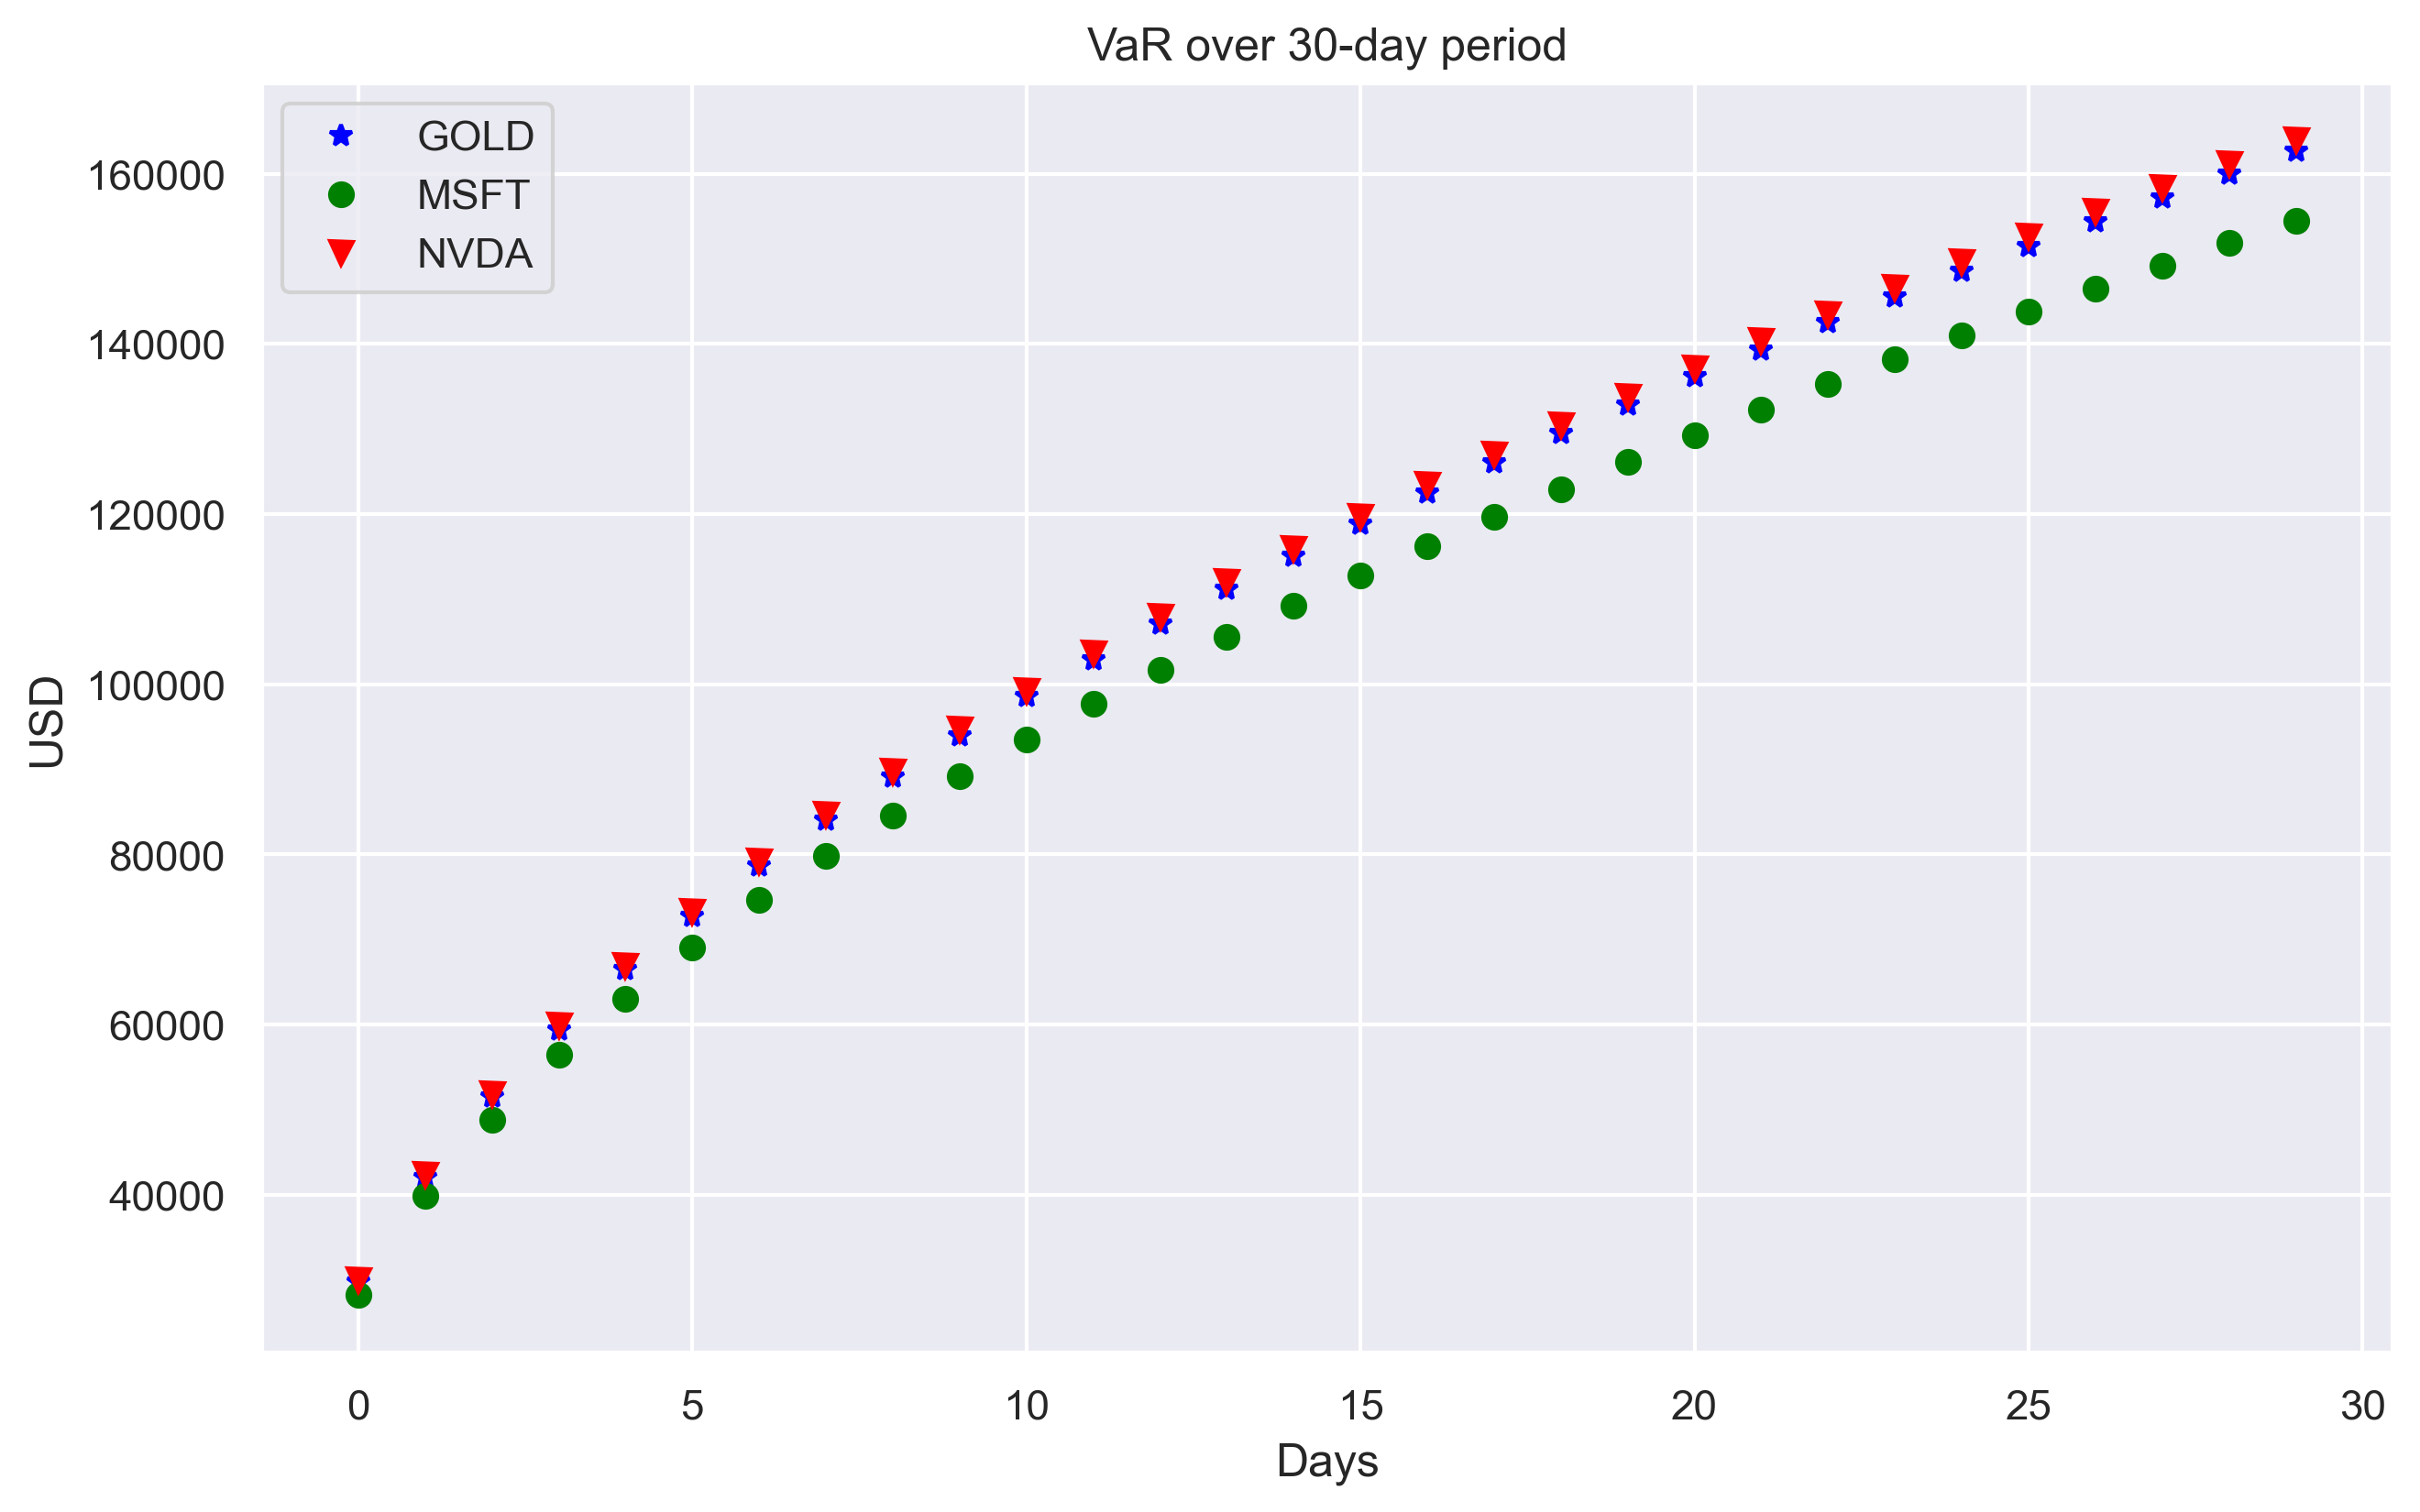

In [68]:
var_horizon = []
time_horizon = 30
for j in range(len(stocks_returns.columns)):
    for i in range(1, time_horizon + 1):
        var_horizon.append(VaR_param[j] * np.sqrt(i))
plt.plot(var_horizon[:time_horizon], "o",
         c='blue', marker='*', label='GOLD')
plt.plot(var_horizon[time_horizon:time_horizon + 30], "o",
         c='green', marker='o', label='MSFT')
plt.plot(var_horizon[time_horizon + 30:time_horizon + 60], "o",
         c='red', marker='v', label='NVDA')
plt.xlabel("Days")
plt.ylabel("USD")
plt.title("VaR over 30-day period")
plt.legend()
plt.show()

## Historical


In [69]:
for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
    print(np.percentile(stocks_returns.loc[:, i], 5))

-0.026801661188673487
-0.05131181406631904
-0.06154277460248707


In [70]:
stocks_returns.loc[:, 'NVDA.O']

Date
2021-01-05    0.021967
2021-01-06   -0.060762
2021-01-07     0.05622
2021-01-08   -0.005052
2021-01-11    0.025635
                ...   
2025-09-24   -0.008216
2025-09-25     0.00406
2025-09-26     0.00281
2025-09-29    0.020332
2025-09-30    0.025678
Name: NVDA.O, Length: 1190, dtype: Float64

In [71]:
np.percentile(stocks_returns.loc[:, 'NVDA.O'], 5)

-0.05131181406631904

In [72]:
def VaR_historical(initial_investment, conf_level):
    Hist_percentile95 = []
    for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
        Hist_percentile95.append(np.percentile(stocks_returns.loc[:, i],
                                               5))
        print("Based on historical values 95% of {}'s return is {:.4f}"
              .format(i, Hist_percentile95[j]))
        VaR_historical = (initial_investment - initial_investment *
                          (1 + Hist_percentile95[j]))
        print("Historical VaR result for {} is {:.2f} "
              .format(i, VaR_historical))
        print('--' * 35)

In [73]:
VaR_historical(initial_investment,conf_level)

Based on historical values 95% of MSFT.O's return is -0.0268
Historical VaR result for MSFT.O is 26801.66 
----------------------------------------------------------------------
Based on historical values 95% of NVDA.O's return is -0.0513
Historical VaR result for NVDA.O is 51311.81 
----------------------------------------------------------------------
Based on historical values 95% of TSLA.N's return is -0.0615
Historical VaR result for TSLA.N is 61542.77 
----------------------------------------------------------------------


## Monte Carlo VaR

In [74]:
x = np.random.uniform(-1, 1, 100) 
y = np.random.uniform(-1, 1, 100)

In [75]:
y

array([ 0.16348137, -0.62766271,  0.31426884, -0.12777425,  0.20342984,
       -0.05533013,  0.25757175, -0.93724902, -0.93608637,  0.03595409,
       -0.52384641, -0.30043188,  0.71634044, -0.95896807, -0.75836932,
        0.55978676, -0.34162176, -0.09474272, -0.69979242, -0.34820431,
        0.99802409,  0.46752264,  0.48722672, -0.42459998,  0.56135006,
        0.6084282 , -0.98358353,  0.27012018, -0.01777207,  0.31831908,
       -0.97298874, -0.63839001, -0.50278203, -0.44037846,  0.08473653,
        0.9742874 , -0.05882989,  0.30401966, -0.65857875,  0.09270206,
       -0.88205265, -0.78685095, -0.01604301, -0.21445138, -0.24323057,
        0.60331243, -0.88532113, -0.64501359, -0.03044209,  0.05690646,
       -0.10544595, -0.94494774, -0.18402245,  0.15493023,  0.20696073,
       -0.7046234 , -0.65238586,  0.26283145,  0.94224325,  0.66868864,
        0.73818119,  0.40270154,  0.71598755, -0.16481144,  0.60861279,
        0.1590131 ,  0.08685016, -0.512439  ,  0.5990426 , -0.21

In [76]:
x

array([-0.82001229, -0.28408378,  0.32827341,  0.98080088,  0.19684471,
        0.88519027,  0.16763766,  0.60491211, -0.4222418 ,  0.56568592,
        0.41167696, -0.539698  , -0.78173407, -0.53112557, -0.28995398,
        0.47634118,  0.57070332, -0.85311853, -0.40026933,  0.30320491,
        0.03806219, -0.20132658, -0.9766926 ,  0.03279091, -0.06685954,
       -0.36389132, -0.70613707, -0.00180001,  0.85911918, -0.93874671,
        0.54552293, -0.56935806, -0.24361174,  0.77423822, -0.96444848,
        0.18317434,  0.2441085 ,  0.38551691, -0.80114223,  0.98285933,
        0.25297355,  0.74396712, -0.1643016 ,  0.41555563, -0.29284075,
       -0.96326704,  0.69857417,  0.27212327, -0.21739836,  0.1770834 ,
        0.47602785,  0.11112289,  0.45465292, -0.64005727,  0.75284443,
       -0.38868595, -0.83074425, -0.48599177, -0.30324244,  0.74450349,
        0.40555573,  0.71787665,  0.61248798, -0.18261292,  0.58318065,
        0.31074056,  0.90788937,  0.41752512, -0.75555824, -0.96

In [77]:
sample = 100    
def pi_calc(x, y):
    point_inside_circle = 0
    for i in range(sample):
        if np.sqrt(x[i] ** 2 + y[i] ** 2) <= 1:
            point_inside_circle += 1 
    print('pi value is {}'.format(4 * point_inside_circle/sample))

In [78]:
pi_calc(x,y)

pi value is 3.28


In [79]:
len(stocks.columns)

3

In [80]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    print(i)

0
1
2


In [81]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    mean = np.random.randn(n).mean()
    std = np.random.randn(n).std()
    temp = pd.DataFrame(np.random.normal(mean, std, num_reps))
    sim_data = pd.concat([sim_data, temp], axis=1)
sim_data.columns = ['Simulation 1', 'Simulation 2', 'Simulation 3']

In [82]:
sim_data

,Simulation 1,Simulation 2,Simulation 3
0,0.487278,-0.129540,-1.771733
1,2.094580,-0.125326,-0.506466
2,-0.695486,0.073194,-0.726872
3,0.103324,-0.775166,-0.214557
4,-0.166969,0.597982,-1.381521
...,...,...,...
995,0.767734,0.872340,-0.529182
996,2.038239,-0.663511,0.771072
997,0.450787,-0.593779,-0.091991
998,0.261575,-1.952179,-0.098127


In [83]:
MC_percentile95 = []
for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
    print(i,j)

Simulation 1 0
Simulation 2 1
Simulation 3 2


In [84]:
def MC_VaR(initial_investment, conf_level):
    MC_percentile95 = []
    for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
        MC_percentile95.append(np.percentile(sim_data.loc[:, i], 5))
        print("Based on simulation 95% of {}'s return is {:.4f}"
              .format(i, MC_percentile95[j]))
        VaR_MC = (initial_investment - initial_investment * 
                  (1 + MC_percentile95[j]))
        print("Simulation VaR result for {} is {:.2f} "
              .format(i, VaR_MC))
        print('--' * 35)

In [85]:
MC_VaR(initial_investment, conf_level)

Based on simulation 95% of Simulation 1's return is -1.8214
Simulation VaR result for Simulation 1 is 1821422.80 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 2's return is -1.5554
Simulation VaR result for Simulation 2 is 1555436.87 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 3's return is -1.5959
Simulation VaR result for Simulation 3 is 1595930.83 
----------------------------------------------------------------------
